In [55]:
# Standard libraries
import numpy as np
import pandas as pd
import json
from collections import defaultdict, Counter
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Number of actions: 50
Train states shape: (9613, 64)
Train actions shape: (9613,)
Epoch 1/50, Train Loss: 2.7453, Val Loss: 2.5189, Val Acc: 32.40%
Epoch 2/50, Train Loss: 2.3003, Val Loss: 2.2667, Val Acc: 34.48%
Epoch 3/50, Train Loss: 2.0970, Val Loss: 2.1390, Val Acc: 37.23%
Epoch 4/50, Train Loss: 1.9421, Val Loss: 1.9403, Val Acc: 43.89%
Epoch 5/50, Train Loss: 1.7579, Val Loss: 1.7820, Val Acc: 46.01%
Epoch 6/50, Train Loss: 1.5842, Val Loss: 1.6303, Val Acc: 46.42%
Epoch 7/50, Train Loss: 1.4972, Val Loss: 1.6108, Val Acc: 45.63%
Epoch 8/50, Train Loss: 1.4524, Val Loss: 1.5538, Val Acc: 48.21%
Epoch 9/50, Train Loss: 1.4385, Val Loss: 1.5176, Val Acc: 48.92%
Epoch 10/50, Train Loss: 1.4054, Val Loss: 1.5047, Val Acc: 49.88%
Epoch 11/50, Train Loss: 1.3862, Val Loss: 1.5000, Val Acc: 48.38%
Epoch 12/50, Train Loss: 1.3812, Val Loss: 1.5034, Val Acc: 48.34%
Epoch 13/50, Train Loss: 1.3850, Val Loss: 1.4809, Val Acc: 49.92%
Epoch 14/50, Train Loss: 1.3626, Val Loss: 1.4658, Val A

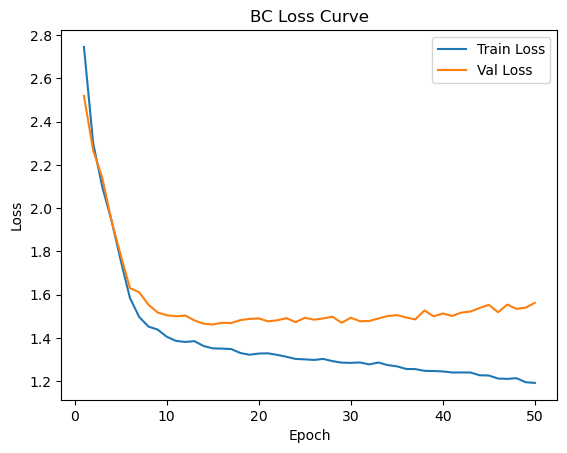

Best validation accuracy: 50.42%


In [56]:
# Converts numpy arrays to Pytorch tensors for custom dataset
class TutorDataset(Dataset):
    def __init__(self, states, actions):
        self.states = torch.tensor(states, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.long)

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, i):
        return self.states[i], self.actions[i]

# FFNN with 2 hidden layers, 256 units each, ReLU activation, 80/20 train/val split
class BCModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def prepare_data_for_bc(csv_file_path):
    df = pd.read_csv(csv_file_path)
    state_features = [
        'misconception_type',
        'convo_turn',
        'previous_action_id',
        'listen_to_feedback',
        'problem_progress',
        'progress_delta',
        'correct_solution',
        'next_action_hint_strength'
    ]
    action_column = 'next_action_id'
    df = df.dropna(subset=[action_column])
    df[action_column] = df[action_column].astype(int)
    categorical_features = ['misconception_type', 'previous_action_id', 'listen_to_feedback', 'correct_solution']
    numerical_features = [f for f in state_features if f not in categorical_features]
    for feature in categorical_features:
        df[feature] = df[feature].fillna(-1)
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].mean() if not df[feature].isna().all() else 0)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[categorical_features])
    numerical_data = df[numerical_features].values
    states = np.hstack((numerical_data, encoded_features))
    actions = df[action_column].values
    unique_actions = np.unique(actions)
    action_map = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_actions))}
    remapped_actions = np.array([action_map[a] for a in actions])
    train_states, val_states, train_actions, val_actions = train_test_split(
        states, remapped_actions, test_size=0.2, random_state=42
    )
    return train_states, val_states, train_actions, val_actions, len(unique_actions)

def train_bc_model(csv_file_path, epochs=50, batch_size=128, lr=1e-3):
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)
    print(f"Number of actions: {num_actions}")
    print(f"Train states shape: {train_states.shape}")
    print(f"Train actions shape: {train_actions.shape}")
    train_ds = TutorDataset(train_states, train_actions)
    val_ds = TutorDataset(val_states, val_actions)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = BCModel(input_dim=train_states.shape[1], output_dim=num_actions)
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for S, A in train_loader:
            logits = model(S)
            loss = criterion(logits, A)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += A.size(0)
            train_correct += (predicted == A).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for S, A in val_loader:
                logits = model(S)
                loss = criterion(logits, A)
                val_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                val_total += A.size(0)
                val_correct += (predicted == A).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_acc = 100 * val_correct / val_total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_bc_model.pt')

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Plot BC loss curve
    plt.figure()
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('BC Loss Curve')
    plt.legend()
    plt.show()

    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return model

if __name__ == "__main__":
    model = train_bc_model('/Users/yp3801/Desktop/PhD/coursework/G1/COS 435/Final Project/FINAL_MATHDIAL.csv')

In [57]:
# stores sequences of state-action-reward transitions (s,a,r,s',done)
class TransitionBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def push(self, s, a, r, s2, done):
        self.states.append(s)
        self.actions.append(a)
        self.rewards.append(r)
        self.next_states.append(s2)
        self.dones.append(done)

    def __len__(self):
        return len(self.actions)

# converts tabular tutoring data into transitions, encode features, organize data based on convo turns
def build_transition_buffer(
    df: pd.DataFrame,
    reward_fn,
    meta_map: dict,
    orig_to_idx: dict,
    episode_column: str = None
):
    """
    Build a transition buffer for offline RL using a 50-action index map and
    its corresponding metadata map.

    Args:
        df: DataFrame with tutoring data; must contain 'next_action_id' and state features.
        reward_fn: function(prev_state, action_idx, next_state, action_meta) -> reward
        meta_map: nested metadata dict mapping category->strategy->(level->idx) for 50 actions
        orig_to_idx: dict mapping original action IDs -> compact indices (0..49)
        episode_column: optional col to group episodes; if None assumes ordered by 'convo_turn'

    Returns:
        buffer: TransitionBuffer of (state, action_idx, reward, next_state, done)
        orig_to_idx: same dict mapping original IDs -> indices (for model sizing)
    """
    # Flatten meta_map into flat_idx_to_meta
    flat_idx_to_meta = {}
    for cat, strategies in meta_map.items():
        for strat, levels in strategies.items():
            for lvl, idx in levels.items():
                flat_idx_to_meta[idx] = {
                    'category': cat,
                    'strategy': strat,
                    'level': lvl
                }

    # State feature setup
    state_feats = ['misconception_type','convo_turn','previous_action_id',
                   'listen_to_feedback','problem_progress','progress_delta',
                   'correct_solution','next_action_hint_strength']
    cat_feats = ['misconception_type','previous_action_id',
                 'listen_to_feedback','correct_solution']
    num_feats = [f for f in state_feats if f not in cat_feats]

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df[cat_feats])

    # Group episodes
    if episode_column:
        episodes = df.sort_values([episode_column,'convo_turn']).groupby(episode_column)
    else:
        df = df.sort_values('convo_turn')
        df['_tmp_ep'] = 1
        episodes = df.groupby('_tmp_ep')

    buffer = TransitionBuffer()

    # Build transitions
    for _, ep_df in episodes:
        prev_state = None
        prev_idx = None
        prev_meta = None

        for _, row in ep_df.iterrows():
            orig_id = row.get('next_action_id')
            if pd.isna(orig_id) or int(orig_id) not in orig_to_idx:
                continue
            orig_id = int(orig_id)
            idx = orig_to_idx[orig_id]

            # encode state
            cat = encoder.transform(pd.DataFrame([row[cat_feats]], columns=cat_feats))
            num = row[num_feats].to_numpy()
            state = np.hstack((num, cat.flatten()))

            meta = flat_idx_to_meta.get(idx)
            # Read done flag from data
            is_done = row.get('done', False)  # Use the actual 'done' column

            if prev_state is not None:
                r = reward_fn(prev_state, prev_idx, state, prev_meta)
                buffer.push(prev_state, prev_idx, r, state, done=is_done)

            prev_state = state
            prev_idx = idx
            prev_meta = meta
    if prev_state is not None:
      terminal_r = new_terminal(prev_state)
      buffer.push(prev_state,
                  prev_idx,
                  terminal_r,
                  prev_state,
                  done=True)
    # convert lists to arrays
    buffer.states = np.array(buffer.states)
    buffer.actions = np.array(buffer.actions, dtype=int)
    buffer.rewards = np.array(buffer.rewards, dtype=float)
    buffer.next_states = np.array(buffer.next_states)
    buffer.dones = np.array(buffer.dones, dtype=bool)

    return buffer, orig_to_idx


# Maximum raw progress
MAX_PROGRESS = 50.0
def new_terminal(state):
    raw_progress = state[4]  # problem_progress in state
    normalized_progress = min(raw_progress, MAX_PROGRESS) / MAX_PROGRESS
    # Higher reward if correct solution was achieved
    return 5.0 if state[6] > 0 else 2.0 * normalized_progress

"""
   The big idea behind the reward function: Good tutors don't just give answers right away... they start with questions and guidance to help students think for themselves, then provide more direct help if the student struggles. This "scaffold then tell" approach is built into the reward function.

   Key design principles:
   1. Always reward student progress, regardless of tutor strategy
   2. Early in a conversation: reward scaffolding (questions, focus), penalize giving answers
   3. Later in a conversation: reduce scaffolding bonuses, reward effective direct instruction
   4. Use a smooth transition between these phases rather than an abrupt switch
   5. Scale penalties based on how "telling" the hint is (revealing answers vs gentle hints)
   6. Keep it simple and avoid hard thresholds or complex calculations

   The reward transitions happen over ~8 turns, which is carefully calibrated for our dataset:
   - With average episode lengths of 15-25 turns, using 8 as the transition denominator makes it so that:
     * First ~3 turns: Strong scaffolding emphasis (turn_progress < 0.4)
     * Middle ~4 turns: Balanced transition phase (turn_progress 0.4-0.7)
     * Remaining turns: Increasing emphasis on problem progress
   - This 8-turn transition worked better than:
     * 5-turn (too fast, not enough guiding emphasis)
     * 10-turn (too slow, many episodes ended before reaching full direct instruction phase)
"""
def hybrid_reward(state, action_id, next_state=None, action_meta=None):
    # Extract key state information
    progress_delta = state[5]
    turn = state[1]

    # Core progress reward and step penalty
    progress_reward = 5.0 * progress_delta
    step_penalty = -0.1

    # Single transition factor (0 to 1) based on turn number
    # Represents how far into the conversation we are
    turn_progress = min(1.0, turn / 8.0)

    # Action-specific adjustment
    strategy_bonus = 0.0

    if action_meta is not None:
        cat = action_meta['category']

        # Guiding/scaffolding actions (Focus, Probing)
        if cat in ['Focus', 'Probing']:
            # Decreasing bonus for scaffolding actions as conversation progresses
            strategy_bonus = 0.2 * (1.0 - turn_progress)

        # Telling actions
        elif cat == 'Telling':
            # Simple hint severity factor
            severity = 1.0
            if 'strategy' in action_meta:
                if action_meta['strategy'] == 'Full Reveal (Answer)':
                    severity = 1.5
                elif action_meta['strategy'] == 'Conceptual Hint':
                    severity = 0.6

            # Early: penalty for telling, Late: bonus for effective telling
            early_penalty = -0.3 * (1.0 - turn_progress) * severity
            late_bonus = 0.0
            if progress_delta > 0:  # Only reward effective telling
                late_bonus = 0.2 * turn_progress

            strategy_bonus = early_penalty + late_bonus

    return progress_reward + step_penalty + strategy_bonus


In [58]:
"""
Asking: if we started from this random state in the buffer and followed the agent's policy, what rewards would the agent have earned if the environment happened to transition exactly as recorded in the buffer?

Terminates if the conversation is done, or by max steps (should be 80), or if the buffer ends
"""
def evaluate_policy(agent, buffer, reward_fn, num_episodes=20, max_steps=80, gamma=0.99, action_meta_map=None):
    """
    Evaluate a policy (BC or CQL) on the transition buffer
    Runs multiple simulated episodes, compute the total reward earned in each episode and report stats

    Args:
        agent: Policy with select_action method (BC or CQL)
        buffer: TransitionBuffer with states, actions, rewards
        reward_fn: Function to compute rewards
        num_episodes: Number of episodes to evaluate
        max_steps: Maximum steps per episode
        gamma: Discount factor
        action_meta_map: Dictionary mapping action indices to metadata

    Returns:
        mean_return: Average return across episodes
        all_returns: List of returns for each episode
    """
    # Put model in eval mode if it has the attribute
    if hasattr(agent, 'q_net') and hasattr(agent.q_net, 'eval'):
        agent.q_net.eval()
    elif hasattr(agent, 'model') and hasattr(agent.model, 'eval'):
        agent.model.eval()

    # Create a flat map from action indices to metadata for easy lookup
    flat_idx_to_meta = {}
    if action_meta_map:
        for cat, strategies in action_meta_map.items():
            for strat, levels in strategies.items():
                for lvl, idx in levels.items():
                    flat_idx_to_meta[idx] = {
                        'category': cat,
                        'strategy': strat,
                        'level': lvl
                    }

    total_returns = []
    episode_lengths = []
    termination_reasons = {"max_steps": 0, "done": 0, "buffer_end": 0}

    # Print buffer inspection info
    # print("\nBuffer inspection:")
    # print(f"  Buffer length: {len(buffer)}")
    # if hasattr(buffer, 'dones'):
    #     dones_count = sum(buffer.dones)
    #     print(f"  Done flags: {dones_count} out of {len(buffer.dones)} ({dones_count/len(buffer.dones)*100:.2f}%)")
    # else:
    #     print("  No 'dones' attribute found in buffer.")

    # Create episodes by sampling starting states

    """
    The agent can choose its actions, but the enviornment transitions are constrained to what already exists in the buffer
    """
    for ep in range(num_episodes):
        # Sample a random starting state
        start_idx = np.random.randint(0, len(buffer) - max_steps)

        # Make sure we get a NumPy array (handle both tensor and numpy inputs)
        if isinstance(buffer.states[start_idx], torch.Tensor):
            state = buffer.states[start_idx].cpu().numpy()
        else:
            state = buffer.states[start_idx].copy()

        episode_return = 0
        episode_length = 0
        discount = 1.0

        # Print starting state info
        # print(f"\nEpisode {ep+1}:")
        # print(f"  Starting index: {start_idx}")
        # print(f"  Initial state features (first 5): {state[:5]}")

        for step in range(max_steps):
            # Select action using the policy
            action_idx = agent.select_action(state)

            # Get next state by sampling from buffer
            """
            Chosen action is ignored, just move sequentially through buffer
            Rewards are calculated by the action the agent chose, though
            """
            next_idx = min(start_idx + step + 1, len(buffer) - 1)

            # Make sure I get a numpy array for the next state
            if isinstance(buffer.states[next_idx], torch.Tensor):
                next_state = buffer.states[next_idx].cpu().numpy()
            else:
                next_state = buffer.states[next_idx].copy()

            # Check for done flag
            done = False
            if hasattr(buffer, 'dones') and len(buffer.dones) > next_idx:
                done = buffer.dones[next_idx]

            # Get action metadata if available
            action_meta = None
            if action_meta_map:
                # Use the already-created mapping instead of recreating it
                action_meta = flat_idx_to_meta.get(action_idx)

            # Compute reward
            reward = reward_fn(state, action_idx, next_state, action_meta)

            # Update return
            episode_return += discount * reward
            discount *= gamma
            episode_length += 1

            # Update state
            state = next_state

            # Check for termination due to done flag
            if done:
                termination_reasons["done"] += 1
                # print(f"  Episode terminated due to done flag at step {step+1}")
                break

            # Check for termination due to max steps
            if step >= max_steps - 1:
                termination_reasons["max_steps"] += 1
                break

            # Check if reached the end of the buffer
            if next_idx >= len(buffer) - 1:
                termination_reasons["buffer_end"] += 1
                # print(f"  Episode terminated due to buffer end at step {step+1}")
                break

        total_returns.append(episode_return)
        episode_lengths.append(episode_length)

        # Print episode summary
        # print(f"  Episode {ep+1} summary:")
        # print(f"    Return: {episode_return:.2f}")
        # print(f"    Length: {episode_length}")

    mean_return = np.mean(total_returns)
    std_return = np.std(total_returns)

    print(f"\nEvaluation over {num_episodes} episodes:")
    print(f"  Mean return: {mean_return:.4f} ± {std_return:.4f}")
    print(f"  Mean episode length: {np.mean(episode_lengths):.2f}")
    print(f"  Termination reasons: {termination_reasons}")

    return mean_return, total_returns


Evaluating BC policy performance:

Evaluation over 50 episodes:
  Mean return: 15.1203 ± 16.8119
  Mean episode length: 20.08
  Termination reasons: {'max_steps': 5, 'done': 45, 'buffer_end': 0}

Transition Buffer Statistics:
Total transitions: 12017
State dimension: 64
Number of unique actions: 50
Baseline BC policy return: 15.1203
Episode return std: 16.8119


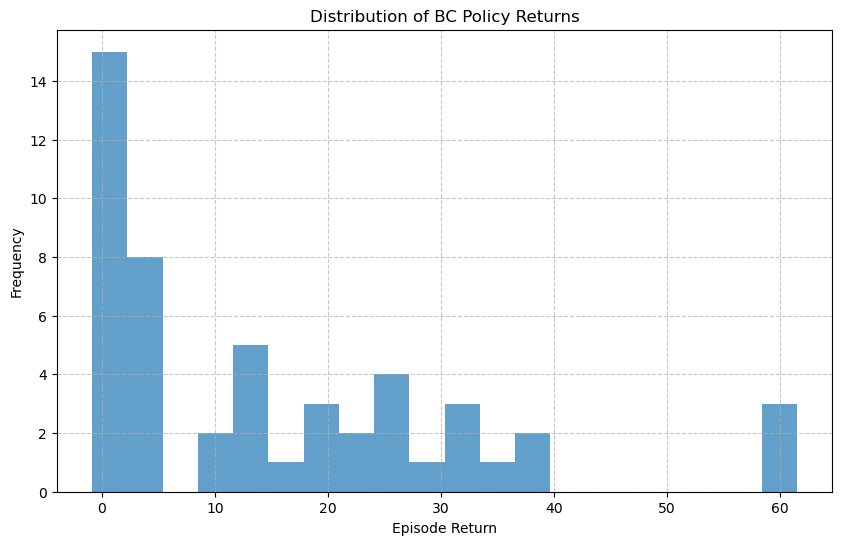

In [59]:
"""
A class to wrap the BC model to make it more compatible with the evaluation framework
1. Takes a trained BC model and an action mapping dictionary
2. Has a select_action method that takes a state and returns an action index
"""
class BCPolicyWrapper:
    def __init__(self, model, action_map, device="cpu"):
        self.model = model.to(device)
        # Also create q_net reference for compatibility with CQL interface
        self.q_net = self.model  # Alias for compatibility
        self.inv_map = {v: k for k, v in action_map.items()}
        self.device = device

    def select_action(self, state):
        """Select best action according to BC policy"""
        # Convert state to tensor if it's not already
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        else:
            # If already tensor, ensure it has batch dimension and is on correct device
            if state.dim() == 1:
                state = state.unsqueeze(0)
            state = state.to(self.device)
        # Return the action with the highest logit value (highest prob)
        with torch.no_grad():
            logits = self.model(state)
            action = logits.argmax(dim=1).item()
        return action

def main():
    # Load trained BC model
    input_dim = 64  # Based on your output
    model = BCModel(input_dim=input_dim, output_dim=50)
    model.load_state_dict(torch.load('best_bc_model.pt'))

    # Load data and preprocess it as before
    csv_file_path = '/Users/yp3801/Desktop/PhD/coursework/G1/COS 435/Final Project/FINAL_MATHDIAL.csv'
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)

    # Create datasets and loaders
    train_ds = TutorDataset(train_states, train_actions)
    val_ds = TutorDataset(val_states, val_actions)
    val_loader = DataLoader(val_ds, batch_size=128)

    # Use the predefined action mappings from system
    action_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 11: 8, 12: 9,
              13: 10, 16: 11, 17: 12, 18: 13, 20: 14, 21: 15, 22: 16, 23: 17,
              26: 18, 27: 19, 28: 20, 31: 21, 32: 22, 36: 23, 37: 24, 38: 25,
              41: 26, 42: 27, 43: 28, 45: 29, 46: 30, 47: 31, 48: 32, 54: 33,
              55: 34, 56: 35, 57: 36, 58: 37, 59: 38, 60: 39, 65: 40, 66: 41,
              67: 42, 70: 43, 71: 44, 72: 45, 73: 46, 75: 47, 76: 48, 77: 49}

    # Define the action metadata map
    action_meta_map = {
        "Focus": {
            "Seek Next Step": {1: 0, 2: 1, 3: 2},
            "Confirm Calculation": {1: 5, 2: 6, 3: 7, 4: 8},
            "Re-direct to Sub-Problem": {2: 11, 3: 12, 4: 13},
            "Highlight Missing Info": {2: 16, 3: 17, 4: 18}
        },
        "Probing": {
            "Ask for Explanation": {1: 20, 2: 21, 3: 22, 4: 23},
            "Seek Self-Correction": {2: 26, 3: 27, 4: 28},
            "Hypothetical Variation": {2: 31, 3: 32},
            "Check Understanding/Concept": {2: 36, 3: 37, 4: 38},
            "Encourage Comparison": {2: 41, 3: 42, 4: 43}
        },
        "Telling": {
            "Partial Reveal (Strategy)": {1: 45, 2: 46, 3: 47, 4: 48},
            "Full Reveal (Answer)": {1: 54, 2: 55, 3: 56, 4: 57, 5: 58, 6: 59},
            "Corrective Explanation": {1: 60}
        },
        "Generic": {
            "Acknowledgment/Praise": {1: 65, 2: 66, 3: 67},
            "Summarize Progress": {1: 70, 2: 71, 3: 72, 4: 73},
            "General Inquiry/Filler": {1: 75, 2: 76, 3: 77}
        }
    }

    feature_names = [
        'misconception_type', 'convo_turn', 'previous_action_id',
        'listen_to_feedback', 'problem_progress', 'progress_delta',
        'correct_solution', 'next_action_hint_strength'
    ]


    # Run off-policy evaluation using the fixed function
    print("\nEvaluating BC policy performance:")

    # First build the transition buffer with all required parameters
    df = pd.read_csv(csv_file_path)

    buffer, action_mapping = build_transition_buffer(
        df=df,
        reward_fn=hybrid_reward,
        meta_map=action_meta_map,
        orig_to_idx=action_map,
        episode_column=None
    )

    # Create a BC policy wrapper for evaluation
    bc_agent = BCPolicyWrapper(model, action_map)

    # Evaluate the policy using the fixed function
    mean_return, episode_returns = evaluate_policy(
        agent=bc_agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=50,
        max_steps=80,
        action_meta_map=action_meta_map
    )

    # Print summary statistics about the buffer
    print("\nTransition Buffer Statistics:")
    print(f"Total transitions: {len(buffer)}")
    print(f"State dimension: {buffer.states.shape[1]}")
    print(f"Number of unique actions: {len(set(buffer.actions))}")


    print(f"Baseline BC policy return: {mean_return:.4f}")
    print(f"Episode return std: {np.std(episode_returns):.4f}")

    # Plot the distribution of returns
    plt.figure(figsize=(10, 6))
    plt.hist(episode_returns, bins=20, alpha=0.7)
    plt.xlabel('Episode Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of BC Policy Returns')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('bc_returns_distribution.png')
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()

In [60]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
"""
Why CQL?
It's offline and good to ensure a conservatively learned policy - don't overestimate out of distribution action rewards.

Vanilla QL overestimates values for unseen (s,a) pairs, and so CQL adds a regularization term that penalizes Q values for actions not seen in the dataset to make the policy more conservative. This is important in educaitonal settings that can affect student learning outcomes. Also, we don't have a good simulator to interact with the environment.
"""
class CQLAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=256,
        lr=3e-4,
        gamma=0.99,
        tau=0.005,
        cql_alpha=1.0,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.cql_alpha = cql_alpha
        self.device = device

        # 2 Q-networks, target network used for stable learning
        self.q_net = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_net = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # Freeze target network (prevent moving target problem)
        for param in self.target_q_net.parameters():
            param.requires_grad = False

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.training_stats = {
            'q_loss': [],
            'cql_loss': [],
            'total_loss': [],
            'avg_q_values': []
        }

    def select_action(self, state):
        # Select the best action according to the Q-network
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state)
            action = q_values.argmax(dim=1).item()
        return action
    # MOST IMPORTANT!
    def update(self, batch):
        # update the Q network using CQL loss
        states, actions, rewards, next_states, dones = batch
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        batch_size = states.shape[0]

        # Compute Q values and target Q values
        q_values = self.q_net(states)
        with torch.no_grad():
            next_q_values = self.target_q_net(next_states)
            next_actions = next_q_values.argmax(dim=1)
            next_q = next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # TD error for the sampled actions (like vanilla Q learning)
        # Standard Bellman error
        q_values_sampled = q_values.gather(1, actions.unsqueeze(1)).squeeze() # selects the Q values corresponding to the specific action indices that were chosen in the offline dataset (the action demonstrated by the expert at that state)
        td_loss = F.mse_loss(q_values_sampled, target_q)

        # CQL loss: Minimize Q values for actions not in the dataset
        # This implementation follows the simplified CQL version
        logsumexp_q = torch.logsumexp(q_values, dim=1)
        """
        logSumExp(x₁, x₂, ..., xₙ) = log(exp(x₁) + exp(x₂) + ... + exp(xₙ))
        A smooth approximation of the maximum function across the action dimension. When one value is significantly larger than the others, it dominates the sum inside the log (and is differentiable)
        """


        # logsumexp_q is the 'soft' maximum Q value across all actions for each state
        # q_values_sampled is the Q value for the actions in the dataset (actions demonstrated by the expert)
        cql_loss = (logsumexp_q - q_values_sampled).mean()
        """
        When the difference between the max  over all action values for each state and the q val of demonstrated actions is LARGE, it means the model is overestimating Q values for actions not in the dataset.
        Th CQL objective is to MINIMIZE this difference by penalizing the model for overestimation.

        This pushes Q values down for all non-dataset actions while preserving the values for actions the expert tutors actually took.
        """
        # Total loss
        loss = td_loss + self.cql_alpha * cql_loss # add cql regularization term

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network, periodic updates (low tau, low updates) for stable learning
        for param, target_param in zip(self.q_net.parameters(), self.target_q_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Record statistics
        self.training_stats['q_loss'].append(td_loss.item())
        self.training_stats['cql_loss'].append(cql_loss.item())
        self.training_stats['total_loss'].append(loss.item())
        self.training_stats['avg_q_values'].append(q_values.mean().item())

        return td_loss.item(), cql_loss.item(), loss.item()

    def save(self, path):
        """Save the Q-network model"""
        torch.save({
            'q_net': self.q_net.state_dict(),
            'target_q_net': self.target_q_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'training_stats': self.training_stats
        }, path)

    def load(self, path):
        """Load the Q-network model"""
        checkpoint = torch.load(path)
        self.q_net.load_state_dict(checkpoint['q_net'])
        self.target_q_net.load_state_dict(checkpoint['target_q_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.training_stats = checkpoint['training_stats']

    def plot_training_curves(self):
        """Plot the training curves"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot Q loss
        axs[0, 0].plot(self.training_stats['q_loss'])
        axs[0, 0].set_title('TD Loss')
        axs[0, 0].set_xlabel('Updates')
        axs[0, 0].set_ylabel('Loss')

        # Plot CQL loss
        axs[0, 1].plot(self.training_stats['cql_loss'])
        axs[0, 1].set_title('CQL Loss')
        axs[0, 1].set_xlabel('Updates')
        axs[0, 1].set_ylabel('Loss')

        # Plot total loss
        axs[1, 0].plot(self.training_stats['total_loss'])
        axs[1, 0].set_title('Total Loss')
        axs[1, 0].set_xlabel('Updates')
        axs[1, 0].set_ylabel('Loss')

        # Plot average Q values
        axs[1, 1].plot(self.training_stats['avg_q_values'])
        axs[1, 1].set_title('Average Q Values')
        axs[1, 1].set_xlabel('Updates')
        axs[1, 1].set_ylabel('Q Value')

        plt.tight_layout()
        plt.savefig('cql_training_curves.png')
        plt.close()

def prepare_buffer_for_training(buffer, batch_size=128, action_map=None):
    """Convert the transition buffer to PyTorch tensors for training"""
    states = torch.FloatTensor(np.array(buffer.states))

    # Map original action IDs -> model indices
    if action_map:
        mapped_actions = [action_map.get(a, 0) for a in buffer.actions]
        actions = torch.LongTensor(mapped_actions)
    else:
        actions = torch.LongTensor(buffer.actions)

    rewards = torch.FloatTensor(np.array(buffer.rewards))
    next_states = torch.FloatTensor(np.array(buffer.next_states))
    dones = torch.FloatTensor(np.array(buffer.dones))

    dataset = TensorDataset(states, actions, rewards, next_states, dones)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


"""
Train a CQL agent on the given transition buffer
1. Prepare data from the transition buffer
2. Initialize the CQL agent
3. Train over multiple epochs
4. Periodically evaluate performance
4. Save the best model
"""
def train_cql(buffer, state_dim, action_dim, num_epochs=100, batch_size=128,
              hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, cql_alpha=1.0,
              eval_interval=5, model_save_path='cql_agent.pt', action_map=None, action_meta_map=None):
    # Prepare data
    dataloader = prepare_buffer_for_training(buffer, batch_size, action_map)

    # Initialize agent
    agent = CQLAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        lr=lr,
        gamma=gamma,
        tau=tau,
        cql_alpha=cql_alpha
    )

    print(f"Training CQL agent with {len(buffer)} transitions")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")
    print(f"CQL alpha: {cql_alpha}, Learning rate: {lr}")

    # Training loop
    best_eval_return = -float('inf')

    for epoch in range(num_epochs):
        epoch_td_loss = 0
        epoch_cql_loss = 0
        epoch_total_loss = 0
        num_batches = 0

        # Training
        agent.q_net.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            td_loss, cql_loss, total_loss = agent.update(batch)
            epoch_td_loss += td_loss
            epoch_cql_loss += cql_loss
            epoch_total_loss += total_loss
            num_batches += 1

            progress_bar.set_postfix({
                'td_loss': td_loss,
                'cql_loss': cql_loss,
                'total_loss': total_loss
            })

        # Calculate average losses
        epoch_td_loss /= num_batches
        epoch_cql_loss /= num_batches
        epoch_total_loss /= num_batches

        print(f"\nEpoch {epoch+1}/{num_epochs} - TD Loss: {epoch_td_loss:.4f}, "
              f"CQL Loss: {epoch_cql_loss:.4f}, Total Loss: {epoch_total_loss:.4f}")

        # Evaluation
        if (epoch + 1) % eval_interval == 0:
            # Evaluate the policy using the fixed function
            mean_return, _ = evaluate_policy(
                agent=agent,
                buffer=buffer,
                reward_fn=hybrid_reward,
                num_episodes=20,
                max_steps=80,
                action_meta_map=action_meta_map
            )
            print(f"Evaluation - Mean Return: {mean_return:.4f}")

            # Save best model
            if mean_return > best_eval_return:
                best_eval_return = mean_return
                agent.save(model_save_path)
                print(f"New best model saved with return: {best_eval_return:.4f}")

    # Plot training curves
    agent.plot_training_curves()

    # Load the best model for final evaluation
    agent.load(model_save_path)
    # Unpack the tuple here too
    final_mean_return, final_returns = evaluate_policy(
        agent=agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=50,
        max_steps=60
    )
    print(f"\nFinal Evaluation - Mean Return: {final_mean_return:.4f}")

    return agent


"""
Initialize a CQL agent using weights from a pre-trained BC model
Motivation: to give CQL a good starting point, since BC has already learning meaningful state representations (warm start)
"""
def convert_bc_to_cql_model(bc_model, action_dim):
    # Get the input dimension from the BC model
    input_dim = bc_model.net[0].in_features

    # Create a CQL agent with the same dimensions
    cql_agent = CQLAgent(state_dim=input_dim, action_dim=action_dim)

    # Copy the feature extractor weights (first two layers)
    cql_agent.q_net.net[0].weight.data.copy_(bc_model.net[0].weight.data)
    cql_agent.q_net.net[0].bias.data.copy_(bc_model.net[0].bias.data)
    cql_agent.q_net.net[2].weight.data.copy_(bc_model.net[2].weight.data)
    cql_agent.q_net.net[2].bias.data.copy_(bc_model.net[2].bias.data)

    # Initialize the Q-value layer
    # The output dimension will be different, so can't copy directly

    # Copy to target network
    cql_agent.target_q_net.load_state_dict(cql_agent.q_net.state_dict())

    return cql_agent

In [61]:
class RandomAgent:
    def __init__(self, action_dim):
        self.action_dim = action_dim

    def select_action(self, state):
        return np.random.randint(0, self.action_dim)


Transition Buffer Statistics:
Total transitions: 12017
State dimension: 64
Number of unique actions: 50
Could not load models. Training from scratch...

Training CQL from scratch...
Training CQL agent with 12017 transitions
State dim: 64, Action dim: 50
CQL alpha: 2.0, Learning rate: 0.0001


Epoch 1/100: 100%|██████████| 47/47 [00:00<00:00, 414.62it/s, td_loss=4.44, cql_loss=2.62, total_loss=9.68]



Epoch 1/100 - TD Loss: 7.1322, CQL Loss: 3.0770, Total Loss: 13.2861


Epoch 2/100: 100%|██████████| 47/47 [00:00<00:00, 418.28it/s, td_loss=6.2, cql_loss=2.72, total_loss=11.6] 



Epoch 2/100 - TD Loss: 5.2008, CQL Loss: 2.6295, Total Loss: 10.4598


Epoch 3/100: 100%|██████████| 47/47 [00:00<00:00, 311.81it/s, td_loss=4.87, cql_loss=2.6, total_loss=10.1] 



Epoch 3/100 - TD Loss: 4.9180, CQL Loss: 2.5472, Total Loss: 10.0124


Epoch 4/100: 100%|██████████| 47/47 [00:00<00:00, 417.24it/s, td_loss=4.5, cql_loss=2.45, total_loss=9.41] 



Epoch 4/100 - TD Loss: 4.8505, CQL Loss: 2.4701, Total Loss: 9.7908


Epoch 5/100: 100%|██████████| 47/47 [00:00<00:00, 323.81it/s, td_loss=4.52, cql_loss=2.27, total_loss=9.05]



Epoch 5/100 - TD Loss: 4.8896, CQL Loss: 2.3935, Total Loss: 9.6765

Evaluation over 20 episodes:
  Mean return: 13.8011 ± 15.8037
  Mean episode length: 21.30
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 13.8011
New best model saved with return: 13.8011


Epoch 6/100: 100%|██████████| 47/47 [00:00<00:00, 412.35it/s, td_loss=5.28, cql_loss=2.33, total_loss=9.93]



Epoch 6/100 - TD Loss: 4.9037, CQL Loss: 2.3425, Total Loss: 9.5887


Epoch 7/100: 100%|██████████| 47/47 [00:00<00:00, 325.95it/s, td_loss=5.95, cql_loss=2.37, total_loss=10.7]



Epoch 7/100 - TD Loss: 4.9345, CQL Loss: 2.2885, Total Loss: 9.5114


Epoch 8/100: 100%|██████████| 47/47 [00:00<00:00, 423.47it/s, td_loss=5.62, cql_loss=2.33, total_loss=10.3]



Epoch 8/100 - TD Loss: 4.9401, CQL Loss: 2.2445, Total Loss: 9.4290


Epoch 9/100: 100%|██████████| 47/47 [00:00<00:00, 383.19it/s, td_loss=5.14, cql_loss=2.13, total_loss=9.4] 



Epoch 9/100 - TD Loss: 4.9198, CQL Loss: 2.1967, Total Loss: 9.3131


Epoch 10/100: 100%|██████████| 47/47 [00:00<00:00, 319.39it/s, td_loss=5, cql_loss=2.1, total_loss=9.2]     



Epoch 10/100 - TD Loss: 4.8588, CQL Loss: 2.1664, Total Loss: 9.1915

Evaluation over 20 episodes:
  Mean return: 21.1504 ± 23.3488
  Mean episode length: 28.00
  Termination reasons: {'max_steps': 5, 'done': 15, 'buffer_end': 0}
Evaluation - Mean Return: 21.1504
New best model saved with return: 21.1504


Epoch 11/100: 100%|██████████| 47/47 [00:00<00:00, 425.32it/s, td_loss=5, cql_loss=2.01, total_loss=9.02]   



Epoch 11/100 - TD Loss: 4.7980, CQL Loss: 2.1329, Total Loss: 9.0638


Epoch 12/100: 100%|██████████| 47/47 [00:00<00:00, 204.17it/s, td_loss=5.28, cql_loss=2.11, total_loss=9.5] 



Epoch 12/100 - TD Loss: 4.7368, CQL Loss: 2.1082, Total Loss: 8.9532


Epoch 13/100: 100%|██████████| 47/47 [00:00<00:00, 426.21it/s, td_loss=4.7, cql_loss=2.15, total_loss=9.01] 



Epoch 13/100 - TD Loss: 4.6335, CQL Loss: 2.0845, Total Loss: 8.8025


Epoch 14/100: 100%|██████████| 47/47 [00:00<00:00, 387.86it/s, td_loss=4.27, cql_loss=2.02, total_loss=8.31]



Epoch 14/100 - TD Loss: 4.4960, CQL Loss: 2.0687, Total Loss: 8.6334


Epoch 15/100: 100%|██████████| 47/47 [00:00<00:00, 317.02it/s, td_loss=4.83, cql_loss=2.06, total_loss=8.94]



Epoch 15/100 - TD Loss: 4.3636, CQL Loss: 2.0523, Total Loss: 8.4681

Evaluation over 20 episodes:
  Mean return: 18.1624 ± 20.5217
  Mean episode length: 24.95
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 18.1624


Epoch 16/100: 100%|██████████| 47/47 [00:00<00:00, 425.18it/s, td_loss=4.05, cql_loss=2.06, total_loss=8.18]



Epoch 16/100 - TD Loss: 4.2424, CQL Loss: 2.0456, Total Loss: 8.3336


Epoch 17/100: 100%|██████████| 47/47 [00:00<00:00, 325.84it/s, td_loss=4.65, cql_loss=1.96, total_loss=8.57]



Epoch 17/100 - TD Loss: 4.1597, CQL Loss: 2.0320, Total Loss: 8.2238


Epoch 18/100: 100%|██████████| 47/47 [00:00<00:00, 377.61it/s, td_loss=3.57, cql_loss=1.98, total_loss=7.54]



Epoch 18/100 - TD Loss: 4.0619, CQL Loss: 2.0302, Total Loss: 8.1223


Epoch 19/100: 100%|██████████| 47/47 [00:00<00:00, 413.86it/s, td_loss=3.23, cql_loss=1.97, total_loss=7.17]



Epoch 19/100 - TD Loss: 4.0269, CQL Loss: 2.0174, Total Loss: 8.0616


Epoch 20/100: 100%|██████████| 47/47 [00:00<00:00, 326.48it/s, td_loss=5, cql_loss=2.05, total_loss=9.11]   



Epoch 20/100 - TD Loss: 4.0240, CQL Loss: 2.0167, Total Loss: 8.0574

Evaluation over 20 episodes:
  Mean return: 16.1505 ± 18.7380
  Mean episode length: 20.85
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 16.1505


Epoch 21/100: 100%|██████████| 47/47 [00:00<00:00, 387.53it/s, td_loss=4.26, cql_loss=2.04, total_loss=8.34]



Epoch 21/100 - TD Loss: 4.0523, CQL Loss: 2.0149, Total Loss: 8.0821


Epoch 22/100: 100%|██████████| 47/47 [00:00<00:00, 310.93it/s, td_loss=4.73, cql_loss=2, total_loss=8.74]   



Epoch 22/100 - TD Loss: 4.1757, CQL Loss: 2.0048, Total Loss: 8.1853


Epoch 23/100: 100%|██████████| 47/47 [00:00<00:00, 429.61it/s, td_loss=4.31, cql_loss=2.06, total_loss=8.44]



Epoch 23/100 - TD Loss: 4.2877, CQL Loss: 1.9975, Total Loss: 8.2827


Epoch 24/100: 100%|██████████| 47/47 [00:00<00:00, 326.73it/s, td_loss=5.24, cql_loss=2.06, total_loss=9.36]



Epoch 24/100 - TD Loss: 4.4277, CQL Loss: 1.9921, Total Loss: 8.4119


Epoch 25/100: 100%|██████████| 47/47 [00:00<00:00, 368.08it/s, td_loss=5.09, cql_loss=1.94, total_loss=8.97]



Epoch 25/100 - TD Loss: 4.6064, CQL Loss: 1.9913, Total Loss: 8.5891

Evaluation over 20 episodes:
  Mean return: 15.8975 ± 14.7302
  Mean episode length: 23.70
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 15.8975


Epoch 26/100: 100%|██████████| 47/47 [00:00<00:00, 424.83it/s, td_loss=5.45, cql_loss=2.16, total_loss=9.76]



Epoch 26/100 - TD Loss: 4.8227, CQL Loss: 1.9821, Total Loss: 8.7870


Epoch 27/100: 100%|██████████| 47/47 [00:00<00:00, 333.19it/s, td_loss=4.29, cql_loss=2.07, total_loss=8.44]



Epoch 27/100 - TD Loss: 5.0495, CQL Loss: 1.9710, Total Loss: 8.9914


Epoch 28/100: 100%|██████████| 47/47 [00:00<00:00, 376.01it/s, td_loss=5.16, cql_loss=1.96, total_loss=9.09]



Epoch 28/100 - TD Loss: 5.2708, CQL Loss: 1.9667, Total Loss: 9.2042


Epoch 29/100: 100%|██████████| 47/47 [00:00<00:00, 321.66it/s, td_loss=4.77, cql_loss=1.85, total_loss=8.47]



Epoch 29/100 - TD Loss: 5.4981, CQL Loss: 1.9592, Total Loss: 9.4165


Epoch 30/100: 100%|██████████| 47/47 [00:00<00:00, 431.89it/s, td_loss=6, cql_loss=1.95, total_loss=9.89]   



Epoch 30/100 - TD Loss: 5.6861, CQL Loss: 1.9593, Total Loss: 9.6048

Evaluation over 20 episodes:
  Mean return: 11.4725 ± 13.4265
  Mean episode length: 13.75
  Termination reasons: {'max_steps': 1, 'done': 19, 'buffer_end': 0}
Evaluation - Mean Return: 11.4725


Epoch 31/100: 100%|██████████| 47/47 [00:00<00:00, 317.70it/s, td_loss=6.08, cql_loss=2.01, total_loss=10.1]



Epoch 31/100 - TD Loss: 5.9144, CQL Loss: 1.9455, Total Loss: 9.8053


Epoch 32/100: 100%|██████████| 47/47 [00:00<00:00, 376.95it/s, td_loss=4.78, cql_loss=1.89, total_loss=8.57]



Epoch 32/100 - TD Loss: 6.1138, CQL Loss: 1.9488, Total Loss: 10.0115


Epoch 33/100: 100%|██████████| 47/47 [00:00<00:00, 430.27it/s, td_loss=6.99, cql_loss=1.93, total_loss=10.8]



Epoch 33/100 - TD Loss: 6.3346, CQL Loss: 1.9476, Total Loss: 10.2297


Epoch 34/100: 100%|██████████| 47/47 [00:00<00:00, 243.04it/s, td_loss=6.51, cql_loss=1.84, total_loss=10.2]



Epoch 34/100 - TD Loss: 6.5542, CQL Loss: 1.9303, Total Loss: 10.4149


Epoch 35/100: 100%|██████████| 47/47 [00:00<00:00, 385.99it/s, td_loss=7.96, cql_loss=1.91, total_loss=11.8]



Epoch 35/100 - TD Loss: 6.7352, CQL Loss: 1.9307, Total Loss: 10.5967

Evaluation over 20 episodes:
  Mean return: 13.5585 ± 20.0267
  Mean episode length: 17.40
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 13.5585


Epoch 36/100: 100%|██████████| 47/47 [00:00<00:00, 193.03it/s, td_loss=7.03, cql_loss=1.84, total_loss=10.7]



Epoch 36/100 - TD Loss: 6.9045, CQL Loss: 1.9303, Total Loss: 10.7651


Epoch 37/100: 100%|██████████| 47/47 [00:00<00:00, 364.12it/s, td_loss=6.92, cql_loss=1.88, total_loss=10.7]



Epoch 37/100 - TD Loss: 7.1044, CQL Loss: 1.9232, Total Loss: 10.9508


Epoch 38/100: 100%|██████████| 47/47 [00:00<00:00, 324.86it/s, td_loss=6.91, cql_loss=1.97, total_loss=10.9]



Epoch 38/100 - TD Loss: 7.2931, CQL Loss: 1.9081, Total Loss: 11.1093


Epoch 39/100: 100%|██████████| 47/47 [00:00<00:00, 418.95it/s, td_loss=6.97, cql_loss=1.94, total_loss=10.9]



Epoch 39/100 - TD Loss: 7.4755, CQL Loss: 1.9059, Total Loss: 11.2873


Epoch 40/100: 100%|██████████| 47/47 [00:00<00:00, 427.24it/s, td_loss=7.16, cql_loss=1.9, total_loss=10.9] 



Epoch 40/100 - TD Loss: 7.6559, CQL Loss: 1.9166, Total Loss: 11.4890

Evaluation over 20 episodes:
  Mean return: 24.1399 ± 27.0913
  Mean episode length: 30.35
  Termination reasons: {'max_steps': 6, 'done': 14, 'buffer_end': 0}
Evaluation - Mean Return: 24.1399
New best model saved with return: 24.1399


Epoch 41/100: 100%|██████████| 47/47 [00:00<00:00, 299.18it/s, td_loss=8.33, cql_loss=1.86, total_loss=12.1]



Epoch 41/100 - TD Loss: 7.7594, CQL Loss: 1.9050, Total Loss: 11.5695


Epoch 42/100: 100%|██████████| 47/47 [00:00<00:00, 425.63it/s, td_loss=6.42, cql_loss=1.88, total_loss=10.2]



Epoch 42/100 - TD Loss: 7.9170, CQL Loss: 1.8875, Total Loss: 11.6921


Epoch 43/100: 100%|██████████| 47/47 [00:00<00:00, 323.56it/s, td_loss=7.83, cql_loss=1.94, total_loss=11.7]



Epoch 43/100 - TD Loss: 8.0653, CQL Loss: 1.9064, Total Loss: 11.8781


Epoch 44/100: 100%|██████████| 47/47 [00:00<00:00, 373.52it/s, td_loss=9.26, cql_loss=1.92, total_loss=13.1]



Epoch 44/100 - TD Loss: 8.2682, CQL Loss: 1.8936, Total Loss: 12.0554


Epoch 45/100: 100%|██████████| 47/47 [00:00<00:00, 320.76it/s, td_loss=8.29, cql_loss=1.78, total_loss=11.9]



Epoch 45/100 - TD Loss: 8.3582, CQL Loss: 1.8873, Total Loss: 12.1328

Evaluation over 20 episodes:
  Mean return: 17.3513 ± 22.5601
  Mean episode length: 24.65
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 17.3513


Epoch 46/100: 100%|██████████| 47/47 [00:00<00:00, 389.48it/s, td_loss=8.87, cql_loss=1.9, total_loss=12.7] 



Epoch 46/100 - TD Loss: 8.5213, CQL Loss: 1.8920, Total Loss: 12.3054


Epoch 47/100: 100%|██████████| 47/47 [00:00<00:00, 414.45it/s, td_loss=9.49, cql_loss=1.99, total_loss=13.5]



Epoch 47/100 - TD Loss: 8.6311, CQL Loss: 1.8812, Total Loss: 12.3936


Epoch 48/100: 100%|██████████| 47/47 [00:00<00:00, 195.40it/s, td_loss=6.07, cql_loss=1.86, total_loss=9.79]



Epoch 48/100 - TD Loss: 8.7473, CQL Loss: 1.8752, Total Loss: 12.4976


Epoch 49/100: 100%|██████████| 47/47 [00:00<00:00, 426.11it/s, td_loss=9.87, cql_loss=1.91, total_loss=13.7]



Epoch 49/100 - TD Loss: 8.8430, CQL Loss: 1.8786, Total Loss: 12.6002


Epoch 50/100: 100%|██████████| 47/47 [00:00<00:00, 312.87it/s, td_loss=8.72, cql_loss=1.88, total_loss=12.5]



Epoch 50/100 - TD Loss: 9.0020, CQL Loss: 1.8816, Total Loss: 12.7651

Evaluation over 20 episodes:
  Mean return: 13.1201 ± 16.0311
  Mean episode length: 18.65
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 13.1201


Epoch 51/100: 100%|██████████| 47/47 [00:00<00:00, 380.79it/s, td_loss=9.7, cql_loss=1.87, total_loss=13.4] 



Epoch 51/100 - TD Loss: 9.1088, CQL Loss: 1.8650, Total Loss: 12.8388


Epoch 52/100: 100%|██████████| 47/47 [00:00<00:00, 329.77it/s, td_loss=9.76, cql_loss=1.94, total_loss=13.7]



Epoch 52/100 - TD Loss: 9.2077, CQL Loss: 1.8695, Total Loss: 12.9466


Epoch 53/100: 100%|██████████| 47/47 [00:00<00:00, 406.80it/s, td_loss=7.54, cql_loss=1.91, total_loss=11.4]



Epoch 53/100 - TD Loss: 9.3014, CQL Loss: 1.8649, Total Loss: 13.0312


Epoch 54/100: 100%|██████████| 47/47 [00:00<00:00, 296.66it/s, td_loss=9.64, cql_loss=1.8, total_loss=13.2] 



Epoch 54/100 - TD Loss: 9.4097, CQL Loss: 1.8654, Total Loss: 13.1405


Epoch 55/100: 100%|██████████| 47/47 [00:00<00:00, 418.99it/s, td_loss=10.1, cql_loss=1.88, total_loss=13.8]



Epoch 55/100 - TD Loss: 9.5266, CQL Loss: 1.8614, Total Loss: 13.2494

Evaluation over 20 episodes:
  Mean return: 14.9233 ± 19.8834
  Mean episode length: 21.10
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 14.9233


Epoch 56/100: 100%|██████████| 47/47 [00:00<00:00, 426.75it/s, td_loss=9.73, cql_loss=1.91, total_loss=13.6]



Epoch 56/100 - TD Loss: 9.6143, CQL Loss: 1.8645, Total Loss: 13.3433


Epoch 57/100: 100%|██████████| 47/47 [00:00<00:00, 305.51it/s, td_loss=9.12, cql_loss=1.85, total_loss=12.8]



Epoch 57/100 - TD Loss: 9.7305, CQL Loss: 1.8546, Total Loss: 13.4398


Epoch 58/100: 100%|██████████| 47/47 [00:00<00:00, 423.19it/s, td_loss=10.1, cql_loss=1.91, total_loss=13.9]



Epoch 58/100 - TD Loss: 9.8584, CQL Loss: 1.8555, Total Loss: 13.5694


Epoch 59/100: 100%|██████████| 47/47 [00:00<00:00, 325.26it/s, td_loss=10.7, cql_loss=1.83, total_loss=14.3]



Epoch 59/100 - TD Loss: 9.9080, CQL Loss: 1.8495, Total Loss: 13.6070


Epoch 60/100: 100%|██████████| 47/47 [00:00<00:00, 378.23it/s, td_loss=11.3, cql_loss=1.86, total_loss=15]  



Epoch 60/100 - TD Loss: 10.0636, CQL Loss: 1.8536, Total Loss: 13.7708

Evaluation over 20 episodes:
  Mean return: 11.8150 ± 17.9890
  Mean episode length: 15.95
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 11.8150


Epoch 61/100: 100%|██████████| 47/47 [00:00<00:00, 416.26it/s, td_loss=10.2, cql_loss=1.95, total_loss=14.1]



Epoch 61/100 - TD Loss: 10.1616, CQL Loss: 1.8466, Total Loss: 13.8549


Epoch 62/100: 100%|██████████| 47/47 [00:00<00:00, 326.95it/s, td_loss=10.1, cql_loss=1.91, total_loss=13.9]



Epoch 62/100 - TD Loss: 10.1993, CQL Loss: 1.8469, Total Loss: 13.8930


Epoch 63/100: 100%|██████████| 47/47 [00:00<00:00, 426.13it/s, td_loss=10.6, cql_loss=1.81, total_loss=14.2]



Epoch 63/100 - TD Loss: 10.3078, CQL Loss: 1.8429, Total Loss: 13.9936


Epoch 64/100: 100%|██████████| 47/47 [00:00<00:00, 325.20it/s, td_loss=11, cql_loss=1.87, total_loss=14.8]  



Epoch 64/100 - TD Loss: 10.3440, CQL Loss: 1.8361, Total Loss: 14.0162


Epoch 65/100: 100%|██████████| 47/47 [00:00<00:00, 420.83it/s, td_loss=13.4, cql_loss=1.88, total_loss=17.2]



Epoch 65/100 - TD Loss: 10.4606, CQL Loss: 1.8405, Total Loss: 14.1416

Evaluation over 20 episodes:
  Mean return: 13.0955 ± 16.1730
  Mean episode length: 18.35
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 13.0955


Epoch 66/100: 100%|██████████| 47/47 [00:00<00:00, 422.00it/s, td_loss=8.9, cql_loss=1.85, total_loss=12.6] 



Epoch 66/100 - TD Loss: 10.5327, CQL Loss: 1.8431, Total Loss: 14.2190


Epoch 67/100: 100%|██████████| 47/47 [00:00<00:00, 324.75it/s, td_loss=12.7, cql_loss=1.85, total_loss=16.4]



Epoch 67/100 - TD Loss: 10.6027, CQL Loss: 1.8358, Total Loss: 14.2743


Epoch 68/100: 100%|██████████| 47/47 [00:00<00:00, 422.92it/s, td_loss=13.6, cql_loss=1.84, total_loss=17.3]



Epoch 68/100 - TD Loss: 10.6832, CQL Loss: 1.8214, Total Loss: 14.3261


Epoch 69/100: 100%|██████████| 47/47 [00:00<00:00, 323.65it/s, td_loss=9.51, cql_loss=1.91, total_loss=13.3]



Epoch 69/100 - TD Loss: 10.7130, CQL Loss: 1.8375, Total Loss: 14.3880


Epoch 70/100: 100%|██████████| 47/47 [00:00<00:00, 421.05it/s, td_loss=10.8, cql_loss=1.8, total_loss=14.4] 



Epoch 70/100 - TD Loss: 10.7655, CQL Loss: 1.8328, Total Loss: 14.4311

Evaluation over 20 episodes:
  Mean return: 17.1393 ± 21.5650
  Mean episode length: 26.35
  Termination reasons: {'max_steps': 5, 'done': 15, 'buffer_end': 0}
Evaluation - Mean Return: 17.1393


Epoch 71/100: 100%|██████████| 47/47 [00:00<00:00, 327.68it/s, td_loss=10.6, cql_loss=1.89, total_loss=14.4]



Epoch 71/100 - TD Loss: 10.9298, CQL Loss: 1.8204, Total Loss: 14.5706


Epoch 72/100: 100%|██████████| 47/47 [00:00<00:00, 236.32it/s, td_loss=11.7, cql_loss=1.86, total_loss=15.4]



Epoch 72/100 - TD Loss: 10.9615, CQL Loss: 1.8300, Total Loss: 14.6214


Epoch 73/100: 100%|██████████| 47/47 [00:00<00:00, 321.32it/s, td_loss=11.3, cql_loss=1.79, total_loss=14.9]



Epoch 73/100 - TD Loss: 11.0301, CQL Loss: 1.8221, Total Loss: 14.6743


Epoch 74/100: 100%|██████████| 47/47 [00:00<00:00, 367.76it/s, td_loss=12.2, cql_loss=1.75, total_loss=15.7]



Epoch 74/100 - TD Loss: 11.1146, CQL Loss: 1.8190, Total Loss: 14.7526


Epoch 75/100: 100%|██████████| 47/47 [00:00<00:00, 399.48it/s, td_loss=10.2, cql_loss=1.82, total_loss=13.9]



Epoch 75/100 - TD Loss: 11.1695, CQL Loss: 1.8077, Total Loss: 14.7850

Evaluation over 20 episodes:
  Mean return: 12.8994 ± 22.0993
  Mean episode length: 21.20
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 12.8994


Epoch 76/100: 100%|██████████| 47/47 [00:00<00:00, 320.32it/s, td_loss=11, cql_loss=1.74, total_loss=14.4]  



Epoch 76/100 - TD Loss: 11.2284, CQL Loss: 1.8217, Total Loss: 14.8718


Epoch 77/100: 100%|██████████| 47/47 [00:00<00:00, 374.01it/s, td_loss=9.01, cql_loss=1.92, total_loss=12.9]



Epoch 77/100 - TD Loss: 11.3126, CQL Loss: 1.8039, Total Loss: 14.9204


Epoch 78/100: 100%|██████████| 47/47 [00:00<00:00, 297.90it/s, td_loss=10.4, cql_loss=1.78, total_loss=14]  



Epoch 78/100 - TD Loss: 11.3221, CQL Loss: 1.8136, Total Loss: 14.9494


Epoch 79/100: 100%|██████████| 47/47 [00:00<00:00, 412.34it/s, td_loss=12.5, cql_loss=1.81, total_loss=16.1]



Epoch 79/100 - TD Loss: 11.3802, CQL Loss: 1.8114, Total Loss: 15.0030


Epoch 80/100: 100%|██████████| 47/47 [00:00<00:00, 317.95it/s, td_loss=13.4, cql_loss=1.83, total_loss=17]  



Epoch 80/100 - TD Loss: 11.4908, CQL Loss: 1.8043, Total Loss: 15.0994

Evaluation over 20 episodes:
  Mean return: 11.4485 ± 18.2551
  Mean episode length: 18.05
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 11.4485


Epoch 81/100: 100%|██████████| 47/47 [00:00<00:00, 415.39it/s, td_loss=10.1, cql_loss=1.84, total_loss=13.8]



Epoch 81/100 - TD Loss: 11.5389, CQL Loss: 1.8094, Total Loss: 15.1576


Epoch 82/100: 100%|██████████| 47/47 [00:00<00:00, 414.61it/s, td_loss=10.3, cql_loss=1.74, total_loss=13.8]



Epoch 82/100 - TD Loss: 11.5900, CQL Loss: 1.8033, Total Loss: 15.1966


Epoch 83/100: 100%|██████████| 47/47 [00:00<00:00, 327.22it/s, td_loss=8.91, cql_loss=1.77, total_loss=12.4]



Epoch 83/100 - TD Loss: 11.6190, CQL Loss: 1.8027, Total Loss: 15.2244


Epoch 84/100: 100%|██████████| 47/47 [00:00<00:00, 233.54it/s, td_loss=13.5, cql_loss=1.84, total_loss=17.1]



Epoch 84/100 - TD Loss: 11.7336, CQL Loss: 1.7828, Total Loss: 15.2991


Epoch 85/100: 100%|██████████| 47/47 [00:00<00:00, 321.83it/s, td_loss=12.1, cql_loss=1.84, total_loss=15.8]



Epoch 85/100 - TD Loss: 11.7652, CQL Loss: 1.8001, Total Loss: 15.3653

Evaluation over 20 episodes:
  Mean return: 22.9687 ± 17.7969
  Mean episode length: 38.40
  Termination reasons: {'max_steps': 6, 'done': 14, 'buffer_end': 0}
Evaluation - Mean Return: 22.9687


Epoch 86/100: 100%|██████████| 47/47 [00:00<00:00, 416.40it/s, td_loss=13.9, cql_loss=1.86, total_loss=17.7]



Epoch 86/100 - TD Loss: 11.7996, CQL Loss: 1.7913, Total Loss: 15.3821


Epoch 87/100: 100%|██████████| 47/47 [00:00<00:00, 250.43it/s, td_loss=13.8, cql_loss=1.77, total_loss=17.4]



Epoch 87/100 - TD Loss: 11.9043, CQL Loss: 1.7850, Total Loss: 15.4743


Epoch 88/100: 100%|██████████| 47/47 [00:00<00:00, 412.64it/s, td_loss=11, cql_loss=1.78, total_loss=14.6]  



Epoch 88/100 - TD Loss: 11.9340, CQL Loss: 1.7951, Total Loss: 15.5243


Epoch 89/100: 100%|██████████| 47/47 [00:00<00:00, 410.97it/s, td_loss=16, cql_loss=1.68, total_loss=19.4]  



Epoch 89/100 - TD Loss: 11.9913, CQL Loss: 1.7894, Total Loss: 15.5700


Epoch 90/100: 100%|██████████| 47/47 [00:00<00:00, 320.88it/s, td_loss=13.7, cql_loss=1.86, total_loss=17.4]



Epoch 90/100 - TD Loss: 11.9979, CQL Loss: 1.7862, Total Loss: 15.5702

Evaluation over 20 episodes:
  Mean return: 21.5753 ± 22.4002
  Mean episode length: 26.10
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 21.5753


Epoch 91/100: 100%|██████████| 47/47 [00:00<00:00, 408.27it/s, td_loss=13.2, cql_loss=1.78, total_loss=16.7]



Epoch 91/100 - TD Loss: 12.0686, CQL Loss: 1.7837, Total Loss: 15.6360


Epoch 92/100: 100%|██████████| 47/47 [00:00<00:00, 311.62it/s, td_loss=11.7, cql_loss=1.82, total_loss=15.4]



Epoch 92/100 - TD Loss: 12.0792, CQL Loss: 1.7821, Total Loss: 15.6434


Epoch 93/100: 100%|██████████| 47/47 [00:00<00:00, 346.20it/s, td_loss=12.8, cql_loss=1.78, total_loss=16.3]



Epoch 93/100 - TD Loss: 12.1367, CQL Loss: 1.7802, Total Loss: 15.6971


Epoch 94/100: 100%|██████████| 47/47 [00:00<00:00, 320.87it/s, td_loss=12.8, cql_loss=1.77, total_loss=16.3]



Epoch 94/100 - TD Loss: 12.1670, CQL Loss: 1.7801, Total Loss: 15.7271


Epoch 95/100: 100%|██████████| 47/47 [00:00<00:00, 413.72it/s, td_loss=11.1, cql_loss=1.84, total_loss=14.8]



Epoch 95/100 - TD Loss: 12.2669, CQL Loss: 1.7764, Total Loss: 15.8198

Evaluation over 20 episodes:
  Mean return: 11.8778 ± 15.7494
  Mean episode length: 17.00
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 11.8778


Epoch 96/100: 100%|██████████| 47/47 [00:00<00:00, 361.32it/s, td_loss=13, cql_loss=1.78, total_loss=16.5]  



Epoch 96/100 - TD Loss: 12.2835, CQL Loss: 1.7729, Total Loss: 15.8293


Epoch 97/100: 100%|██████████| 47/47 [00:00<00:00, 284.12it/s, td_loss=9.89, cql_loss=1.73, total_loss=13.3]



Epoch 97/100 - TD Loss: 12.2849, CQL Loss: 1.7681, Total Loss: 15.8210


Epoch 98/100: 100%|██████████| 47/47 [00:00<00:00, 354.87it/s, td_loss=10.9, cql_loss=1.75, total_loss=14.4]



Epoch 98/100 - TD Loss: 12.3394, CQL Loss: 1.7712, Total Loss: 15.8818


Epoch 99/100: 100%|██████████| 47/47 [00:00<00:00, 281.79it/s, td_loss=13.4, cql_loss=1.76, total_loss=16.9]



Epoch 99/100 - TD Loss: 12.4082, CQL Loss: 1.7704, Total Loss: 15.9491


Epoch 100/100: 100%|██████████| 47/47 [00:00<00:00, 408.55it/s, td_loss=10.3, cql_loss=1.66, total_loss=13.7]



Epoch 100/100 - TD Loss: 12.4856, CQL Loss: 1.7661, Total Loss: 16.0177

Evaluation over 20 episodes:
  Mean return: 17.9550 ± 17.1066
  Mean episode length: 22.75
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 17.9550

Evaluation over 50 episodes:
  Mean return: 13.4455 ± 15.9026
  Mean episode length: 19.24
  Termination reasons: {'max_steps': 9, 'done': 41, 'buffer_end': 0}

Final Evaluation - Mean Return: 13.4455

Training BC-initialized CQL...
Training CQL agent with 12017 transitions
State dim: 64, Action dim: 50
CQL alpha: 0.9, Learning rate: 3e-05


Epoch 1/30: 100%|██████████| 47/47 [00:00<00:00, 256.77it/s, td_loss=7.86, cql_loss=3.23, total_loss=10.8]



Epoch 1/30 - TD Loss: 8.7147, CQL Loss: 3.7253, Total Loss: 12.0674


Epoch 2/30: 100%|██████████| 47/47 [00:00<00:00, 330.15it/s, td_loss=5.13, cql_loss=2.87, total_loss=7.71]



Epoch 2/30 - TD Loss: 6.2200, CQL Loss: 2.9794, Total Loss: 8.9015


Epoch 3/30: 100%|██████████| 47/47 [00:00<00:00, 291.49it/s, td_loss=4.62, cql_loss=2.73, total_loss=7.07]



Epoch 3/30 - TD Loss: 5.3952, CQL Loss: 2.8118, Total Loss: 7.9258


Epoch 4/30: 100%|██████████| 47/47 [00:00<00:00, 259.04it/s, td_loss=4.92, cql_loss=2.73, total_loss=7.38]



Epoch 4/30 - TD Loss: 5.0794, CQL Loss: 2.7481, Total Loss: 7.5527


Epoch 5/30: 100%|██████████| 47/47 [00:00<00:00, 343.24it/s, td_loss=4.83, cql_loss=2.73, total_loss=7.29]



Epoch 5/30 - TD Loss: 4.9236, CQL Loss: 2.7278, Total Loss: 7.3786

Evaluation over 20 episodes:
  Mean return: 20.1840 ± 18.5530
  Mean episode length: 29.40
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 20.1840
New best model saved with return: 20.1840


Epoch 6/30: 100%|██████████| 47/47 [00:00<00:00, 199.04it/s, td_loss=5.18, cql_loss=2.7, total_loss=7.61] 



Epoch 6/30 - TD Loss: 4.8828, CQL Loss: 2.7086, Total Loss: 7.3205


Epoch 7/30: 100%|██████████| 47/47 [00:00<00:00, 268.93it/s, td_loss=5.05, cql_loss=2.72, total_loss=7.5] 



Epoch 7/30 - TD Loss: 4.9122, CQL Loss: 2.6742, Total Loss: 7.3189


Epoch 8/30: 100%|██████████| 47/47 [00:00<00:00, 280.78it/s, td_loss=4.41, cql_loss=2.56, total_loss=6.72]



Epoch 8/30 - TD Loss: 4.9434, CQL Loss: 2.6518, Total Loss: 7.3301


Epoch 9/30: 100%|██████████| 47/47 [00:00<00:00, 249.94it/s, td_loss=5.29, cql_loss=2.62, total_loss=7.64]



Epoch 9/30 - TD Loss: 4.9828, CQL Loss: 2.6373, Total Loss: 7.3563


Epoch 10/30: 100%|██████████| 47/47 [00:00<00:00, 341.79it/s, td_loss=3.79, cql_loss=2.53, total_loss=6.06]



Epoch 10/30 - TD Loss: 5.0441, CQL Loss: 2.6066, Total Loss: 7.3900

Evaluation over 20 episodes:
  Mean return: 29.3873 ± 24.6217
  Mean episode length: 43.05
  Termination reasons: {'max_steps': 9, 'done': 11, 'buffer_end': 0}
Evaluation - Mean Return: 29.3873
New best model saved with return: 29.3873


Epoch 11/30: 100%|██████████| 47/47 [00:00<00:00, 252.37it/s, td_loss=4.23, cql_loss=2.56, total_loss=6.53]



Epoch 11/30 - TD Loss: 5.1170, CQL Loss: 2.5879, Total Loss: 7.4462


Epoch 12/30: 100%|██████████| 47/47 [00:00<00:00, 259.15it/s, td_loss=4.87, cql_loss=2.62, total_loss=7.22]



Epoch 12/30 - TD Loss: 5.1896, CQL Loss: 2.5780, Total Loss: 7.5098


Epoch 13/30: 100%|██████████| 47/47 [00:00<00:00, 273.84it/s, td_loss=5.9, cql_loss=2.59, total_loss=8.24] 



Epoch 13/30 - TD Loss: 5.2763, CQL Loss: 2.5566, Total Loss: 7.5772


Epoch 14/30: 100%|██████████| 47/47 [00:00<00:00, 348.26it/s, td_loss=4.57, cql_loss=2.53, total_loss=6.85]



Epoch 14/30 - TD Loss: 5.3558, CQL Loss: 2.5397, Total Loss: 7.6416


Epoch 15/30: 100%|██████████| 47/47 [00:00<00:00, 268.83it/s, td_loss=5.84, cql_loss=2.57, total_loss=8.15]



Epoch 15/30 - TD Loss: 5.4233, CQL Loss: 2.5353, Total Loss: 7.7051

Evaluation over 20 episodes:
  Mean return: 13.7333 ± 17.1676
  Mean episode length: 18.90
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 13.7333


Epoch 16/30: 100%|██████████| 47/47 [00:00<00:00, 215.60it/s, td_loss=5.14, cql_loss=2.55, total_loss=7.43]



Epoch 16/30 - TD Loss: 5.5115, CQL Loss: 2.5119, Total Loss: 7.7722


Epoch 17/30: 100%|██████████| 47/47 [00:00<00:00, 333.30it/s, td_loss=5.39, cql_loss=2.55, total_loss=7.69]



Epoch 17/30 - TD Loss: 5.5827, CQL Loss: 2.5067, Total Loss: 7.8388


Epoch 18/30: 100%|██████████| 47/47 [00:00<00:00, 285.21it/s, td_loss=5.08, cql_loss=2.49, total_loss=7.32]



Epoch 18/30 - TD Loss: 5.6530, CQL Loss: 2.4946, Total Loss: 7.8981


Epoch 19/30: 100%|██████████| 47/47 [00:00<00:00, 181.99it/s, td_loss=5.23, cql_loss=2.51, total_loss=7.49]



Epoch 19/30 - TD Loss: 5.7245, CQL Loss: 2.4826, Total Loss: 7.9589


Epoch 20/30: 100%|██████████| 47/47 [00:00<00:00, 272.57it/s, td_loss=6.25, cql_loss=2.53, total_loss=8.53]



Epoch 20/30 - TD Loss: 5.7793, CQL Loss: 2.4726, Total Loss: 8.0046

Evaluation over 20 episodes:
  Mean return: 23.5462 ± 23.9536
  Mean episode length: 37.10
  Termination reasons: {'max_steps': 8, 'done': 12, 'buffer_end': 0}
Evaluation - Mean Return: 23.5462


Epoch 21/30: 100%|██████████| 47/47 [00:00<00:00, 335.08it/s, td_loss=6.52, cql_loss=2.56, total_loss=8.82]



Epoch 21/30 - TD Loss: 5.8678, CQL Loss: 2.4464, Total Loss: 8.0696


Epoch 22/30: 100%|██████████| 47/47 [00:00<00:00, 268.53it/s, td_loss=5.57, cql_loss=2.48, total_loss=7.79]



Epoch 22/30 - TD Loss: 5.9087, CQL Loss: 2.4395, Total Loss: 8.1043


Epoch 23/30: 100%|██████████| 47/47 [00:00<00:00, 271.43it/s, td_loss=7.04, cql_loss=2.44, total_loss=9.23]



Epoch 23/30 - TD Loss: 5.9717, CQL Loss: 2.4276, Total Loss: 8.1566


Epoch 24/30: 100%|██████████| 47/47 [00:00<00:00, 277.43it/s, td_loss=5.83, cql_loss=2.46, total_loss=8.04]



Epoch 24/30 - TD Loss: 6.0168, CQL Loss: 2.4224, Total Loss: 8.1969


Epoch 25/30: 100%|██████████| 47/47 [00:00<00:00, 350.66it/s, td_loss=6.25, cql_loss=2.36, total_loss=8.38]



Epoch 25/30 - TD Loss: 6.0538, CQL Loss: 2.4064, Total Loss: 8.2195

Evaluation over 20 episodes:
  Mean return: 13.3802 ± 14.5915
  Mean episode length: 15.30
  Termination reasons: {'max_steps': 1, 'done': 19, 'buffer_end': 0}
Evaluation - Mean Return: 13.3802


Epoch 26/30: 100%|██████████| 47/47 [00:00<00:00, 271.63it/s, td_loss=5.55, cql_loss=2.23, total_loss=7.56]



Epoch 26/30 - TD Loss: 6.1079, CQL Loss: 2.3852, Total Loss: 8.2546


Epoch 27/30: 100%|██████████| 47/47 [00:00<00:00, 276.34it/s, td_loss=6.19, cql_loss=2.44, total_loss=8.39]



Epoch 27/30 - TD Loss: 6.1332, CQL Loss: 2.3801, Total Loss: 8.2752


Epoch 28/30: 100%|██████████| 47/47 [00:00<00:00, 340.22it/s, td_loss=7.3, cql_loss=2.32, total_loss=9.39] 



Epoch 28/30 - TD Loss: 6.1787, CQL Loss: 2.3688, Total Loss: 8.3107


Epoch 29/30: 100%|██████████| 47/47 [00:00<00:00, 272.76it/s, td_loss=5.7, cql_loss=2.32, total_loss=7.79] 



Epoch 29/30 - TD Loss: 6.2215, CQL Loss: 2.3453, Total Loss: 8.3323


Epoch 30/30: 100%|██████████| 47/47 [00:00<00:00, 268.60it/s, td_loss=6.69, cql_loss=2.43, total_loss=8.88]



Epoch 30/30 - TD Loss: 6.2579, CQL Loss: 2.3449, Total Loss: 8.3683

Evaluation over 20 episodes:
  Mean return: 10.8094 ± 15.6553
  Mean episode length: 14.00
  Termination reasons: {'max_steps': 1, 'done': 19, 'buffer_end': 0}
Evaluation - Mean Return: 10.8094

Evaluation over 50 episodes:
  Mean return: 14.9373 ± 14.2605
  Mean episode length: 22.86
  Termination reasons: {'max_steps': 12, 'done': 38, 'buffer_end': 0}

Final Evaluation - Mean Return: 14.9373

Evaluating models on same starting states...

Evaluating 100 episodes with same starting states for all models:


100%|██████████| 100/100 [00:00<00:00, 521.31it/s]


Model Comparison (fair evaluation):
Random policy return:        12.7773 ± 13.1385
BC policy return:            12.3313 ± 12.5991
Standard CQL policy return:  13.2581 ± 13.7220 (7.5% vs BC)
BC-init CQL policy return:   13.2581 ± 13.7220 (7.5% vs BC)

Paired t-test results:
BC vs CQL:          t=-4.3876, p=0.0000 (significant)
BC vs BC-init CQL:  t=-4.3876, p=0.0000 (significant)
CQL vs BC-init CQL: t=nan, p=nan (not significant)



/var/folders/z9/653v3vq92w3306ryvh4d809h0000gp/T/ipykernel_13915/2057605989.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=labels)


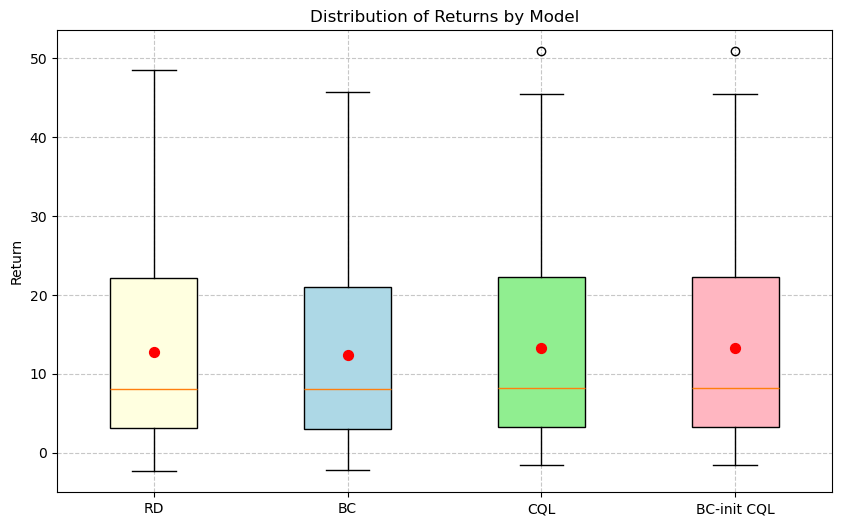

Evaluation complete. Results saved to 'fair_evaluation_returns.npz'


In [62]:
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

"""
Run all three models on same start sequence with discount factor of 0.98
"""
def evaluate_all_models_on_same_states(rd_agent, bc_agent, cql_agent, bc_init_cql_agent, buffer, reward_fn, num_episodes=50, max_steps=80, action_meta_map=None):
    print(f"\nEvaluating {num_episodes} episodes with same starting states for all models:")

    # Create flat mapping for metadata
    flat_idx_to_meta = {}
    if action_meta_map:
        for cat, strategies in action_meta_map.items():
            for strat, levels in strategies.items():
                for lvl, idx in levels.items():
                    flat_idx_to_meta[idx] = {
                        'category': cat,
                        'strategy': strat,
                        'level': lvl
                    }

    # Generate random starting indices for all episodes
    start_indices = np.random.randint(0, len(buffer) - max_steps, size=num_episodes)

    # Initialize arrays to store results
    rd_returns = np.zeros(num_episodes)
    bc_returns = np.zeros(num_episodes)
    cql_returns = np.zeros(num_episodes)
    bc_init_returns = np.zeros(num_episodes)

    # Evaluate each episode
    for ep_idx, start_idx in enumerate(tqdm(start_indices)):
        # Process same starting state for each model
        for model_idx, (agent, returns_array) in enumerate([
            (rd_agent, rd_returns),
            (bc_agent, bc_returns),
            (cql_agent, cql_returns),
            (bc_init_cql_agent, bc_init_returns)
        ]):
            # Get initial state
            state = buffer.states[start_idx].copy()

            # Initialize episode tracking
            episode_return = 0
            discount = 1.0

            # Run the episode
            for step in range(max_steps):
                # Select action using the policy
                action_idx = agent.select_action(state)

                # Get next state by sampling from buffer
                next_idx = min(start_idx + step + 1, len(buffer) - 1)
                next_state = buffer.states[next_idx].copy()

                # Check for done flag
                done = False
                if hasattr(buffer, 'dones') and len(buffer.dones) > next_idx:
                    done = buffer.dones[next_idx]

                # Get action metadata if available
                action_meta = flat_idx_to_meta.get(action_idx, None)

                # Compute reward
                reward = reward_fn(state, action_idx, next_state, action_meta)

                # Update return
                episode_return += discount * reward
                discount *= 0.98  # Use gamma from training

                # Update state
                state = next_state

                # Check termination conditions
                if done or next_idx >= len(buffer) - 1:
                    break

            # Store the return for this model and episode
            returns_array[ep_idx] = episode_return

    return rd_returns, bc_returns, cql_returns, bc_init_returns

"""
Perform paired t-tests to check for statistical significance
"""
def perform_paired_t_test(bc_returns, cql_returns, bc_init_returns):
    # BC vs CQL
    bc_cql_t, bc_cql_p = stats.ttest_rel(bc_returns, cql_returns)

    # BC vs BC-Init CQL
    bc_init_t, bc_init_p = stats.ttest_rel(bc_returns, bc_init_returns)

    # CQL vs BC-Init CQL
    cql_init_t, cql_init_p = stats.ttest_rel(cql_returns, bc_init_returns)

    print("\nPaired t-test results:")
    print(f"BC vs CQL:          t={bc_cql_t:.4f}, p={bc_cql_p:.4f} {'(significant)' if bc_cql_p < 0.05 else '(not significant)'}")
    print(f"BC vs BC-init CQL:  t={bc_init_t:.4f}, p={bc_init_p:.4f} {'(significant)' if bc_init_p < 0.05 else '(not significant)'}")
    print(f"CQL vs BC-init CQL: t={cql_init_t:.4f}, p={cql_init_p:.4f} {'(significant)' if cql_init_p < 0.05 else '(not significant)'}")

    return {
        'bc_cql': (bc_cql_t, bc_cql_p),
        'bc_init': (bc_init_t, bc_init_p),
        'cql_init': (cql_init_t, cql_init_p)
    }


def plot_returns_comparison(rd_returns, bc_returns, cql_returns, bc_init_returns):
    """
    Create a box plot comparing the return distributions of all models
    """
    plt.figure(figsize=(10, 6))

    data = [rd_returns, bc_returns, cql_returns, bc_init_returns]
    labels = ['RD', 'BC', 'CQL', 'BC-init CQL']

    box = plt.boxplot(data, patch_artist=True, labels=labels)
    colors = ['lightyellow','lightblue', 'lightgreen', 'lightpink']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    for i, d in enumerate(data):
        plt.scatter(i+1, np.mean(d), marker='o', color='red', s=50, zorder=10)

    plt.ylabel('Return')
    plt.title('Distribution of Returns by Model')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig('returns_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def main():
    # Load trained BC model
    input_dim = 64
    output_dim = 50  # Number of unique actions
    bc_model = BCModel(input_dim=input_dim, output_dim=output_dim)
    bc_model.load_state_dict(torch.load('best_bc_model.pt'))

    # Load data
    csv_file_path = '/Users/yp3801/Desktop/PhD/coursework/G1/COS 435/Final Project/FINAL_MATHDIAL.csv'
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)

    # Define action mappings
    # Original action IDs to model indices (0-49)
    action_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 11: 8, 12: 9,
                 13: 10, 16: 11, 17: 12, 18: 13, 20: 14, 21: 15, 22: 16, 23: 17,
                 26: 18, 27: 19, 28: 20, 31: 21, 32: 22, 36: 23, 37: 24, 38: 25,
                 41: 26, 42: 27, 43: 28, 45: 29, 46: 30, 47: 31, 48: 32, 54: 33,
                 55: 34, 56: 35, 57: 36, 58: 37, 59: 38, 60: 39, 65: 40, 66: 41,
                 67: 42, 70: 43, 71: 44, 72: 45, 73: 46, 75: 47, 76: 48, 77: 49}

    # Define the metadata map
    action_meta_map = {
        "Focus": {
            "Seek Next Step": {1: 0, 2: 1, 3: 2},
            "Confirm Calculation": {1: 5, 2: 6, 3: 7, 4: 8},
            "Re-direct to Sub-Problem": {2: 11, 3: 12, 4: 13},
            "Highlight Missing Info": {2: 16, 3: 17, 4: 18}
        },
        "Probing": {
            "Ask for Explanation": {1: 20, 2: 21, 3: 22, 4: 23},
            "Seek Self-Correction": {2: 26, 3: 27, 4: 28},
            "Hypothetical Variation": {2: 31, 3: 32},
            "Check Understanding/Concept": {2: 36, 3: 37, 4: 38},
            "Encourage Comparison": {2: 41, 3: 42, 4: 43}
        },
        "Telling": {
            "Partial Reveal (Strategy)": {1: 45, 2: 46, 3: 47, 4: 48},
            "Full Reveal (Answer)": {1: 54, 2: 55, 3: 56, 4: 57, 5: 58, 6: 59},
            "Corrective Explanation": {1: 60}
        },
        "Generic": {
            "Acknowledgment/Praise": {1: 65, 2: 66, 3: 67},
            "Summarize Progress": {1: 70, 2: 71, 3: 72, 4: 73},
            "General Inquiry/Filler": {1: 75, 2: 76, 3: 77}
        }
    }

    # Load dataframe for the transition buffer
    df = pd.read_csv(csv_file_path)

    # Build the transition buffer with enhanced reward function
    buffer, returned_action_map = build_transition_buffer(
        df=df,
        reward_fn=hybrid_reward,
        meta_map=action_meta_map,
        orig_to_idx=action_map,
        episode_column=None
    )

    # Print buffer statistics
    print(f"\nTransition Buffer Statistics:")
    print(f"Total transitions: {len(buffer)}")
    print(f"State dimension: {buffer.states.shape[1]}")
    print(f"Number of unique actions: {len(set(buffer.actions))}")

    # Check if models are already trained (if not, train them)
    try:
        # Try to load the CQL models
        cql_agent = CQLAgent(state_dim=buffer.states.shape[1], action_dim=output_dim)
        cql_agent.load('best_cql_model.pt')

        bc_init_cql_agent = CQLAgent(state_dim=buffer.states.shape[1], action_dim=output_dim)
        bc_init_cql_agent.load('best_initialized_cql_model.pt')

        print("Successfully loaded pre-trained models.")
    except:
        print("Could not load models. Training from scratch...")

        # Option 1: Train CQL from scratch
        print("\nTraining CQL from scratch...")
        cql_agent = train_cql(
            buffer=buffer,
            state_dim=buffer.states.shape[1],
            action_dim=output_dim,
            num_epochs=100,
            batch_size=256,
            hidden_dim=256,
            lr=1e-4,
            gamma=0.98,
            tau=0.005,
            cql_alpha=2.0,
            model_save_path='best_cql_model.pt',
            action_map=action_map,
            action_meta_map=action_meta_map
        )

        # Option 2: Initialize CQL with BC weights
        print("\nTraining BC-initialized CQL...")
        bc_initialized_cql = convert_bc_to_cql_model(bc_model, output_dim)
        bc_initialized_cql.save('bc_initialized_cql.pt')

        bc_init_cql_agent = train_cql(
            buffer=buffer,
            state_dim=buffer.states.shape[1],
            action_dim=output_dim,
            num_epochs=30,
            batch_size=256,
            hidden_dim=256,
            lr=3e-5,
            gamma=0.98,
            tau=0.005,
            cql_alpha=0.9,
            model_save_path='best_initialized_cql_model.pt',
            action_map=action_map,
            action_meta_map=action_meta_map
        )

    # Wrap BC for consistent interface
    bc_agent = BCPolicyWrapper(bc_model, action_map, device=cql_agent.device)
    rd_agent = RandomAgent(action_dim=output_dim)

    # Evaluate all models on the same starting states
    print("\nEvaluating models on same starting states...")
    rd_returns, bc_returns, cql_returns, bc_init_returns = evaluate_all_models_on_same_states(
        rd_agent=rd_agent,
        bc_agent=bc_agent,
        cql_agent=cql_agent,
        bc_init_cql_agent=bc_init_cql_agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=100,  # Increased for better statistical significance
        max_steps=60,
        action_meta_map=action_meta_map
    )

    # Calculate means and standard deviations
    rd_mean = np.mean(rd_returns)
    bc_mean = np.mean(bc_returns)
    cql_mean = np.mean(cql_returns)
    bc_init_mean = np.mean(bc_init_returns)

    rd_std = np.std(rd_returns)
    bc_std = np.std(bc_returns)
    cql_std = np.std(cql_returns)
    bc_init_std = np.std(bc_init_returns)

    # Print comparison
    print("\nModel Comparison (fair evaluation):")
    print(f"Random policy return:        {rd_mean:.4f} ± {rd_std:.4f}")
    print(f"BC policy return:            {bc_mean:.4f} ± {bc_std:.4f}")
    print(f"Standard CQL policy return:  {cql_mean:.4f} ± {cql_std:.4f} ({(cql_mean-bc_mean)/abs(bc_mean)*100:.1f}% vs BC)")
    print(f"BC-init CQL policy return:   {bc_init_mean:.4f} ± {bc_init_std:.4f} ({(bc_init_mean-bc_mean)/abs(bc_mean)*100:.1f}% vs BC)")

    # Perform paired t-tests
    test_results = perform_paired_t_test(bc_returns, cql_returns, bc_init_returns)

    # Plot return distributions
    plot_returns_comparison(rd_returns, bc_returns, cql_returns, bc_init_returns)

    # Save returns for future analysis
    np.savez('fair_evaluation_returns.npz',
             bc_returns=bc_returns,
             cql_returns=cql_returns,
             bc_init_returns=bc_init_returns)

    print("Evaluation complete. Results saved to 'fair_evaluation_returns.npz'")


if __name__ == "__main__":
    main()